# Correlations: How Social Media and the Forex Market Relate

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle

Data retrived from [histdata.com](http://www.histdata.com/download-free-forex-historical-data/?/metatrader/1-minute-bar-quotes/usdmxn/2016/10)

In [56]:
# Loading intraday FX: USD v.s. MXN
usd_mxn = pd.read_csv("DAT_MT_USDMXN_M1_201610.csv", names=["Date","Time","tick","t2","t3","t4","t5"])
usd_mxn = usd_mxn[["Date", "Time", "tick"]]

format_time = lambda strtime: strtime.replace(":",".")
to_datetime = lambda input_list: datetime(*[int(x) for x in input_list.split(".")])

# Format Date and time and place it as the index
usd_mxn.index = (usd_mxn["Date"] + "." + usd_mxn["Time"].apply(format_time)).apply(to_datetime)
usd_mxn.drop(["Date", "Time"], axis=1, inplace=True)

In [57]:
usd_mxn.head(5)

,tick
2016-10-02 17:01:00,19.37168
2016-10-02 17:02:00,19.36975
2016-10-02 17:03:00,19.37475
2016-10-02 17:09:00,19.37475
2016-10-02 17:14:00,19.36730


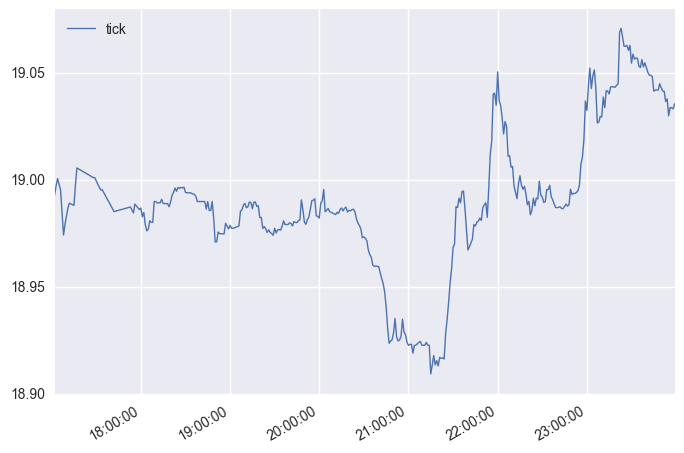

In [77]:
usd_mxn[usd_mxn.index.day == 9].plot(linewidth=1)
plt.show()

In [23]:
"test,this,is".split(",")

['test', 'this', 'is']

In [28]:
datetime(*[int(x) for x in usd_mxn.Date[1].split(".")])

datetime.datetime(2016, 10, 2, 0, 0)